In [ ]:
# import
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm



In [ ]:
# Apply Transforms
# apply transform function for train and test seperately.. 
# The reason is that test data is used as inference and not all transforms used for training would be applicable.. for example cutouts


train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ]) 

# transforms to convert the image to tensor and normalize using mean and std dev precalculated (per channel)
# there are other transforms as well, but will settle with basic ones for now. 

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [ ]:
# Download Data which already has the test train split

# this downloads the data and stores in local folder "./data/MNIST/raw" 

# REFER TO THE FOLDER STRUCTURE

train = datasets.MNIST('./data',train=True,transform=train_transforms,download=True)
test = datasets.MNIST('./data',train=False,transform=test_transforms,download=True)

# Try out few commands
# train


In [ ]:
# Data Loader - Batch
SEED=1

# check if cuda is available
cuda = torch.cuda.is_available()
#cuda 

#for reproducability
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader arguments

# 128 batchsize if cuda else 64 batch size (CPU)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# dataloader_args

#Train loader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args) 

# Test loader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)



In [ ]:
# Visualize the data and data statistics

# WHOLE TRAINING SET - DATA STATISTICS

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print('-Numpy Shape', train.train_data.cpu().numpy().shape)
print('-tensor shape', train.train_data.size())
print('min', torch.min(train_data))
print('max', torch.max(train_data))
print('mean', torch.mean(train_data))
print('std', torch.std(train_data))
print('var', torch.var(train_data))


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
-Numpy Shape (60000, 28, 28)
-tensor shape torch.Size([60000, 28, 28])
min tensor(-0.4242)
max tensor(2.8215)
mean tensor(-0.0002)
std tensor(1.0000)
var tensor(1.0001)


torch.Size([128, 1, 28, 28])
torch.Size([128])
numpy shape of 1st image (1, 28, 28)
image format (28, 28)


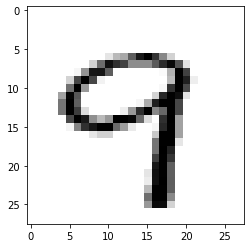

In [ ]:
# visualize images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

# how to transform the tensor to an image to visualize
print('numpy shape of 1st image', images[0].numpy().shape)  # (1,28,28)
print('image format', images[0].numpy().squeeze().shape) # squeeze removes the channel. 

%matplotlib inline
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

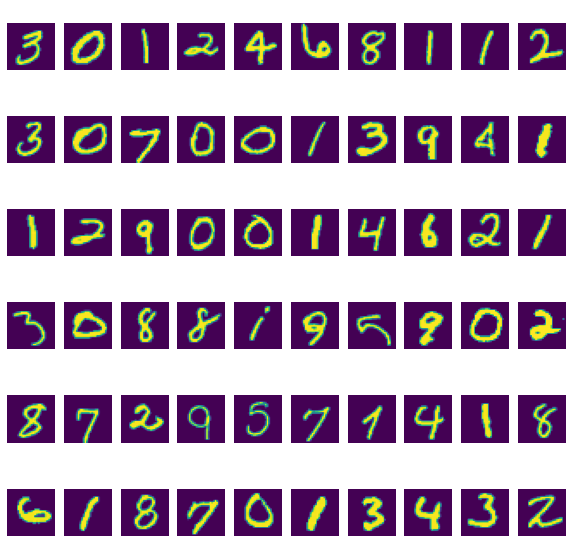

In [ ]:
# more visualization

figure = plt.figure(figsize=(10,10))
num_of_images = 60

for index in range(1,num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='white')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


mean of raw data is  33.318421449829934
mean of pytorch tensor after transformation is :  tensor(0.1305)
39.661989795918366 (28, 28)
tensor(0.1305) torch.Size([60000, 28])


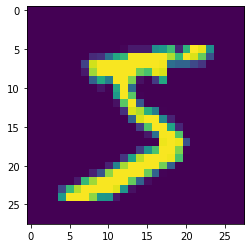

In [ ]:


simple_transforms = transforms.Compose([transforms.ToTensor()])
exp = datasets.MNIST('./data',train=True, transform=simple_transforms, download=True)

plt.imshow(exp.train_data.numpy()[0])
print('mean of raw data is ', train.train_data.numpy().mean())
print('mean of pytorch tensor after transformation is : ',torch.mean(exp.transform(exp.train_data.numpy())))

# without Transform
temp = exp.train_data.numpy() # does not normalize the values
print(temp[1].mean(), temp[1].shape)

# apply tensor transform
temp = exp.transform(temp) # when you apply transforms, it normalizes. 
print(temp.mean(), temp[1].shape)


In [ ]:
# Check on mean of data - Parameters for Normalization
# download the train data without transforms

simple_transforms = transforms.Compose([transforms.ToTensor()])
exp = datasets.MNIST('./data',train=True, transform=simple_transforms, download=True)
exp_data = exp.train_data
print('initial exp_data shape', exp_data.shape)
exp_data = exp.transform(exp_data.numpy())
print('exp data shape',exp_data.shape) # when you run this, the shape would change from [6000x28x28] to [28x6000x28] and normalize it between 0 and 1

print('[TRAIN]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


initial exp_data shape torch.Size([60000, 28, 28])
exp data shape torch.Size([28, 60000, 28])
[TRAIN]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() ,
            nn.Dropout(dropout_value)
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value) 
        ) # output_size = 3

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )


        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) # output_size = 5



    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)

        x = self.gap(x)
        x = self.convblock10(x)

        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [ ]:
# Summary

# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

In [ ]:
# Train and Test Functuions
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
# Train the model with lr scheduler. 

from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.05)


EPOCHS = 20
for epoch in range(EPOCHS):
    
    print("EPOCH:", epoch)
    print('learning rate ', scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()    
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
learning rate  [0.01]


Loss=0.07559268921613693 Batch_id=468 Accuracy=88.78: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9787/10000 (97.87%)

EPOCH: 1
learning rate  [0.01]


Loss=0.16257567703723907 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9861/10000 (98.61%)

EPOCH: 2
learning rate  [0.01]


Loss=0.07778816670179367 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9882/10000 (98.82%)

EPOCH: 3
learning rate  [0.01]


Loss=0.0694158598780632 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 4
learning rate  [0.01]


Loss=0.10851940512657166 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9930/10000 (99.30%)

EPOCH: 5
learning rate  [0.01]


Loss=0.015323594212532043 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.04394539073109627 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 24.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9938/10000 (99.38%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.008804848417639732 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:18<00:00, 25.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.024043546989560127 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:18<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.05561402812600136 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.05184477940201759 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9938/10000 (99.38%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.007857774384319782 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9939/10000 (99.39%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.02076873369514942 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9942/10000 (99.42%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.03702976927161217 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:19<00:00, 24.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9945/10000 (99.45%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.06754659116268158 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 24.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9942/10000 (99.42%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.008098012767732143 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:19<00:00, 24.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9940/10000 (99.40%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.050177570432424545 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9947/10000 (99.47%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.09774980694055557 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9943/10000 (99.43%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.006013917271047831 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:18<00:00, 24.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9939/10000 (99.39%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.006483124103397131 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]



Test set: Average loss: 0.0205, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

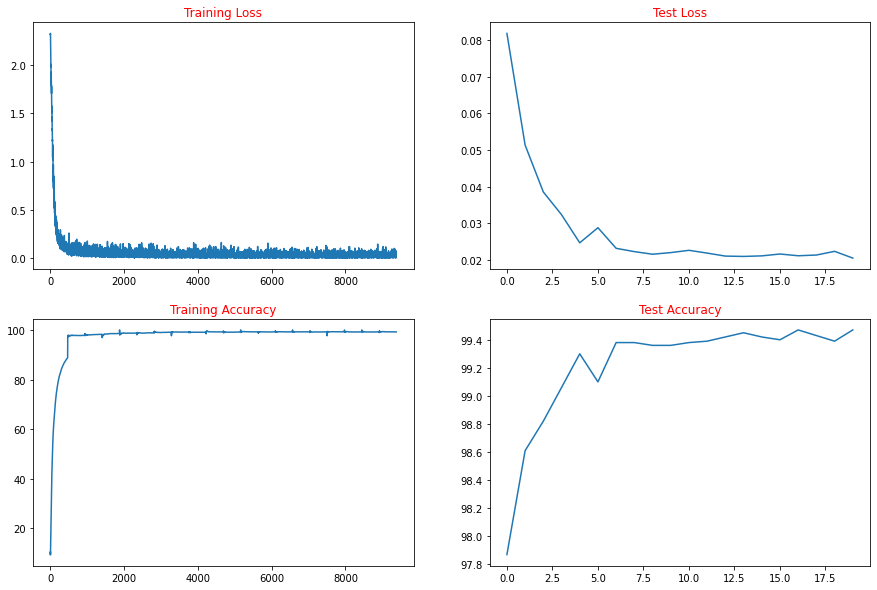

In [ ]:
# Plot the accuracy and loss curves. 
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss",color='r')
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy",color='r')
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss",color='r')
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy", color='r')